In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

torch.set_default_dtype(torch.float64)
np.random.seed(1)
torch.manual_seed(1)

In [14]:
# create dataset
n_grid = 10000
x = np.linspace(-1,1,num=n_grid)
data = x[:,np.newaxis]
truth = data**2

data = torch.tensor(data, dtype=torch.double, requires_grad=True)
truth = torch.tensor(truth, dtype=torch.double, requires_grad=True)

In [15]:
def grow(t1, t2, w_s, w_l):

    w_mask = torch.zeros(w_l,w_l)
    w_mask[:w_s,:w_s] = torch.ones(w_s,w_s)

    b_mask = torch.zeros(w_l,)
    b_mask[:w_s] = torch.ones(w_s,)

    t2.l2.weight.data = t2.l2.weight.data*w_mask
    t2.l2.weight.data[:w_s,:w_s] = t1.l2.weight.data
    t2.l2.bias.data = t2.l2.bias.data*b_mask
    t2.l2.bias.data[:w_s] = t1.l2.bias.data

    t2.l1.weight.data[:w_s,:] = t1.l1.weight.data
    t2.l1.bias.data[:w_s] = t1.l1.bias.data

    t2.l3.weight.data[:,:w_s] = t1.l3.weight.data
    t2.l3.bias.data[:w_s] = t1.l3.bias.data
    return t2

In [16]:
alpha = 0.3

class NN1(nn.Module):
    def __init__(self, w=10):
        super(NN1, self).__init__()
        self.l1 = nn.Linear(1,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,1)
        
    def forward(self, x):
        f = nn.LeakyReLU(alpha)
        #f = nn.ReLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3

In [17]:
n_train = data.shape[0]

#ws = [10,20,40,80]
ws = [3,5,7,9,11,13,15,20,25,30,35,40,80]
#ws = [10]
loss_w = []
w_i = 0

for w in ws:
    
    print("w={}".format(w))
    if w_i == 0:
        model = NN1(w=w)
    else:
        sd = model.state_dict()
        model_old = NN1(w=w_old)
        model_old.load_state_dict(sd)
        model = NN1(w=w)
        model = grow(model_old, model, w_old, w)
    w_i = w_i + 1
    
    
    #model = NN1(w=w)
    #epochs = 10000
    epochs = 50000
    switch_epoch = 10000
    log = 100
    lr = 1e-2
    optimizer = optim.Adam(model.parameters(), lr = lr, eps=1e-8, betas=(0.9,0.999))
    losses = []
    best_loss = 1000

    for epoch in range(epochs):
        batch_size = n_grid

        if (epoch+1) % switch_epoch == 0:    
            for opt_param in optimizer.param_groups:
                lr = lr * 0.3
                opt_param['lr'] = lr
        model.train()
        optimizer.zero_grad()

        choices = np.random.choice(n_train, batch_size, replace=False)
        inputs = data[choices]
        labels = truth[choices]
        outputs = model(inputs)

        loss = torch.mean((outputs-labels)**2)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        
        if loss < best_loss:
            best_loss = loss

        if epoch%log == 0:
            print('Epoch:  %d | loss %.12f ' %(epoch, loss))
    
    loss_w.append(best_loss.detach().numpy())
    w_old = w

w=3
Epoch:  0 | loss 0.150580613846 
Epoch:  100 | loss 0.059573212718 
Epoch:  200 | loss 0.000359986572 
Epoch:  300 | loss 0.000283301917 
Epoch:  400 | loss 0.000270815109 
Epoch:  500 | loss 0.000268665836 
Epoch:  600 | loss 0.000268134602 
Epoch:  700 | loss 0.000267767413 
Epoch:  800 | loss 0.000272614990 
Epoch:  900 | loss 0.000267033586 
Epoch:  1000 | loss 0.000266654163 
Epoch:  1100 | loss 0.000266653858 
Epoch:  1200 | loss 0.000283823728 
Epoch:  1300 | loss 0.000265400967 
Epoch:  1400 | loss 0.000265871550 
Epoch:  1500 | loss 0.000331584901 
Epoch:  1600 | loss 0.000264161313 
Epoch:  1700 | loss 0.000263899343 
Epoch:  1800 | loss 0.000263410375 
Epoch:  1900 | loss 0.000263056090 
Epoch:  2000 | loss 0.000262724052 
Epoch:  2100 | loss 0.000254711906 
Epoch:  2200 | loss 0.000213495532 
Epoch:  2300 | loss 0.000207763445 
Epoch:  2400 | loss 0.000197290085 
Epoch:  2500 | loss 0.000190139224 
Epoch:  2600 | loss 0.000183420877 
Epoch:  2700 | loss 0.000179002774 


Epoch:  22600 | loss 0.000119359239 
Epoch:  22700 | loss 0.000119325670 
Epoch:  22800 | loss 0.000119347516 
Epoch:  22900 | loss 0.000119259505 
Epoch:  23000 | loss 0.000119230374 
Epoch:  23100 | loss 0.000119211739 
Epoch:  23200 | loss 0.000119209362 
Epoch:  23300 | loss 0.000119164725 
Epoch:  23400 | loss 0.000119148849 
Epoch:  23500 | loss 0.000119478077 
Epoch:  23600 | loss 0.000119164898 
Epoch:  23700 | loss 0.000119127275 
Epoch:  23800 | loss 0.000119085978 
Epoch:  23900 | loss 0.000119078016 
Epoch:  24000 | loss 0.000119077518 
Epoch:  24100 | loss 0.000119055330 
Epoch:  24200 | loss 0.000119039690 
Epoch:  24300 | loss 0.000119253697 
Epoch:  24400 | loss 0.000119443489 
Epoch:  24500 | loss 0.000119010660 
Epoch:  24600 | loss 0.000119003113 
Epoch:  24700 | loss 0.000119091727 
Epoch:  24800 | loss 0.000118982227 
Epoch:  24900 | loss 0.000118975549 
Epoch:  25000 | loss 0.000118977550 
Epoch:  25100 | loss 0.000119361639 
Epoch:  25200 | loss 0.000119026465 
E

Epoch:  44800 | loss 0.000068694635 
Epoch:  44900 | loss 0.000068692996 
Epoch:  45000 | loss 0.000068691270 
Epoch:  45100 | loss 0.000068689513 
Epoch:  45200 | loss 0.000068688115 
Epoch:  45300 | loss 0.000068686348 
Epoch:  45400 | loss 0.000068684924 
Epoch:  45500 | loss 0.000068683442 
Epoch:  45600 | loss 0.000068682028 
Epoch:  45700 | loss 0.000068681879 
Epoch:  45800 | loss 0.000068681487 
Epoch:  45900 | loss 0.000068677674 
Epoch:  46000 | loss 0.000068676314 
Epoch:  46100 | loss 0.000068674893 
Epoch:  46200 | loss 0.000068673627 
Epoch:  46300 | loss 0.000068672429 
Epoch:  46400 | loss 0.000068671303 
Epoch:  46500 | loss 0.000068670078 
Epoch:  46600 | loss 0.000068670243 
Epoch:  46700 | loss 0.000068667582 
Epoch:  46800 | loss 0.000068666514 
Epoch:  46900 | loss 0.000068665820 
Epoch:  47000 | loss 0.000068664452 
Epoch:  47100 | loss 0.000068663338 
Epoch:  47200 | loss 0.000068662301 
Epoch:  47300 | loss 0.000068661234 
Epoch:  47400 | loss 0.000068660320 
E

Epoch:  17300 | loss 0.000009884895 
Epoch:  17400 | loss 0.000010652495 
Epoch:  17500 | loss 0.000009879455 
Epoch:  17600 | loss 0.000011021084 
Epoch:  17700 | loss 0.000009874281 
Epoch:  17800 | loss 0.000018588619 
Epoch:  17900 | loss 0.000009868360 
Epoch:  18000 | loss 0.000009899201 
Epoch:  18100 | loss 0.000015488113 
Epoch:  18200 | loss 0.000009861594 
Epoch:  18300 | loss 0.000009868485 
Epoch:  18400 | loss 0.000009857065 
Epoch:  18500 | loss 0.000019218903 
Epoch:  18600 | loss 0.000009853459 
Epoch:  18700 | loss 0.000009850550 
Epoch:  18800 | loss 0.000009863578 
Epoch:  18900 | loss 0.000010026977 
Epoch:  19000 | loss 0.000009844971 
Epoch:  19100 | loss 0.000009851585 
Epoch:  19200 | loss 0.000009841375 
Epoch:  19300 | loss 0.000010942139 
Epoch:  19400 | loss 0.000009838467 
Epoch:  19500 | loss 0.000009836350 
Epoch:  19600 | loss 0.000009834837 
Epoch:  19700 | loss 0.000010152623 
Epoch:  19800 | loss 0.000009833242 
Epoch:  19900 | loss 0.000016836661 
E

Epoch:  39500 | loss 0.000009623836 
Epoch:  39600 | loss 0.000009607508 
Epoch:  39700 | loss 0.000009606340 
Epoch:  39800 | loss 0.000009610477 
Epoch:  39900 | loss 0.000009604059 
Epoch:  40000 | loss 0.000009608311 
Epoch:  40100 | loss 0.000009602588 
Epoch:  40200 | loss 0.000009602249 
Epoch:  40300 | loss 0.000009601899 
Epoch:  40400 | loss 0.000009601528 
Epoch:  40500 | loss 0.000009601127 
Epoch:  40600 | loss 0.000009600712 
Epoch:  40700 | loss 0.000009600281 
Epoch:  40800 | loss 0.000009599773 
Epoch:  40900 | loss 0.000009599279 
Epoch:  41000 | loss 0.000009598784 
Epoch:  41100 | loss 0.000009598270 
Epoch:  41200 | loss 0.000009597721 
Epoch:  41300 | loss 0.000009597137 
Epoch:  41400 | loss 0.000009596534 
Epoch:  41500 | loss 0.000009595890 
Epoch:  41600 | loss 0.000009595200 
Epoch:  41700 | loss 0.000009594437 
Epoch:  41800 | loss 0.000009593680 
Epoch:  41900 | loss 0.000009592890 
Epoch:  42000 | loss 0.000009592078 
Epoch:  42100 | loss 0.000009591240 
E

Epoch:  12000 | loss 0.000006723199 
Epoch:  12100 | loss 0.000006550326 
Epoch:  12200 | loss 0.000006708634 
Epoch:  12300 | loss 0.000006307490 
Epoch:  12400 | loss 0.000006225560 
Epoch:  12500 | loss 0.000012326356 
Epoch:  12600 | loss 0.000005993339 
Epoch:  12700 | loss 0.000010797159 
Epoch:  12800 | loss 0.000005806067 
Epoch:  12900 | loss 0.000005706798 
Epoch:  13000 | loss 0.000005637208 
Epoch:  13100 | loss 0.000005534699 
Epoch:  13200 | loss 0.000005583845 
Epoch:  13300 | loss 0.000005376019 
Epoch:  13400 | loss 0.000005391685 
Epoch:  13500 | loss 0.000005226647 
Epoch:  13600 | loss 0.000005344963 
Epoch:  13700 | loss 0.000005086438 
Epoch:  13800 | loss 0.000005988326 
Epoch:  13900 | loss 0.000004973201 
Epoch:  14000 | loss 0.000004884778 
Epoch:  14100 | loss 0.000004852230 
Epoch:  14200 | loss 0.000004788780 
Epoch:  14300 | loss 0.000005155725 
Epoch:  14400 | loss 0.000004680562 
Epoch:  14500 | loss 0.000004797056 
Epoch:  14600 | loss 0.000005120582 
E

Epoch:  34200 | loss 0.000002022411 
Epoch:  34300 | loss 0.000002021011 
Epoch:  34400 | loss 0.000002031039 
Epoch:  34500 | loss 0.000002018491 
Epoch:  34600 | loss 0.000002019269 
Epoch:  34700 | loss 0.000002016091 
Epoch:  34800 | loss 0.000002015459 
Epoch:  34900 | loss 0.000002013765 
Epoch:  35000 | loss 0.000002012641 
Epoch:  35100 | loss 0.000002012239 
Epoch:  35200 | loss 0.000002012376 
Epoch:  35300 | loss 0.000002010209 
Epoch:  35400 | loss 0.000002008145 
Epoch:  35500 | loss 0.000002011978 
Epoch:  35600 | loss 0.000002005849 
Epoch:  35700 | loss 0.000002004795 
Epoch:  35800 | loss 0.000002003879 
Epoch:  35900 | loss 0.000002002670 
Epoch:  36000 | loss 0.000002002433 
Epoch:  36100 | loss 0.000002001142 
Epoch:  36200 | loss 0.000002000296 
Epoch:  36300 | loss 0.000002078097 
Epoch:  36400 | loss 0.000001997641 
Epoch:  36500 | loss 0.000001996789 
Epoch:  36600 | loss 0.000002053472 
Epoch:  36700 | loss 0.000002001468 
Epoch:  36800 | loss 0.000001994525 
E

Epoch:  6600 | loss 0.000002693254 
Epoch:  6700 | loss 0.000002816080 
Epoch:  6800 | loss 0.000004178637 
Epoch:  6900 | loss 0.000002720718 
Epoch:  7000 | loss 0.000014054880 
Epoch:  7100 | loss 0.000002710896 
Epoch:  7200 | loss 0.000002756687 
Epoch:  7300 | loss 0.000011704943 
Epoch:  7400 | loss 0.000002700532 
Epoch:  7500 | loss 0.000002913654 
Epoch:  7600 | loss 0.000002747879 
Epoch:  7700 | loss 0.000129544849 
Epoch:  7800 | loss 0.000002721606 
Epoch:  7900 | loss 0.000011705818 
Epoch:  8000 | loss 0.000061306174 
Epoch:  8100 | loss 0.000002716946 
Epoch:  8200 | loss 0.000189559059 
Epoch:  8300 | loss 0.000002733342 
Epoch:  8400 | loss 0.000005383348 
Epoch:  8500 | loss 0.000002698867 
Epoch:  8600 | loss 0.000003930470 
Epoch:  8700 | loss 0.000002704223 
Epoch:  8800 | loss 0.000185347304 
Epoch:  8900 | loss 0.000002735828 
Epoch:  9000 | loss 0.000057588306 
Epoch:  9100 | loss 0.000002689726 
Epoch:  9200 | loss 0.000003161004 
Epoch:  9300 | loss 0.000002

Epoch:  28900 | loss 0.000001955058 
Epoch:  29000 | loss 0.000001691823 
Epoch:  29100 | loss 0.000001644734 
Epoch:  29200 | loss 0.000001438991 
Epoch:  29300 | loss 0.000001290304 
Epoch:  29400 | loss 0.000001280644 
Epoch:  29500 | loss 0.000001281187 
Epoch:  29600 | loss 0.000001286012 
Epoch:  29700 | loss 0.000001276469 
Epoch:  29800 | loss 0.000001276254 
Epoch:  29900 | loss 0.000001277133 
Epoch:  30000 | loss 0.000001274180 
Epoch:  30100 | loss 0.000001271905 
Epoch:  30200 | loss 0.000001271499 
Epoch:  30300 | loss 0.000001271074 
Epoch:  30400 | loss 0.000001270627 
Epoch:  30500 | loss 0.000001270164 
Epoch:  30600 | loss 0.000001269684 
Epoch:  30700 | loss 0.000001269169 
Epoch:  30800 | loss 0.000001268634 
Epoch:  30900 | loss 0.000001268082 
Epoch:  31000 | loss 0.000001267490 
Epoch:  31100 | loss 0.000001266866 
Epoch:  31200 | loss 0.000001266224 
Epoch:  31300 | loss 0.000001265550 
Epoch:  31400 | loss 0.000001264841 
Epoch:  31500 | loss 0.000001264101 
E

Epoch:  1100 | loss 0.000001546827 
Epoch:  1200 | loss 0.000001503360 
Epoch:  1300 | loss 0.000009118963 
Epoch:  1400 | loss 0.000001507245 
Epoch:  1500 | loss 0.000001485165 
Epoch:  1600 | loss 0.000001628660 
Epoch:  1700 | loss 0.000001492891 
Epoch:  1800 | loss 0.000001581023 
Epoch:  1900 | loss 0.000001527180 
Epoch:  2000 | loss 0.000001481841 
Epoch:  2100 | loss 0.000060744612 
Epoch:  2200 | loss 0.000001516177 
Epoch:  2300 | loss 0.000001481511 
Epoch:  2400 | loss 0.000202145592 
Epoch:  2500 | loss 0.000001533625 
Epoch:  2600 | loss 0.000001485091 
Epoch:  2700 | loss 0.000001708895 
Epoch:  2800 | loss 0.000001531190 
Epoch:  2900 | loss 0.000001482572 
Epoch:  3000 | loss 0.000023373023 
Epoch:  3100 | loss 0.000001502949 
Epoch:  3200 | loss 0.000007804725 
Epoch:  3300 | loss 0.000017776284 
Epoch:  3400 | loss 0.000001505951 
Epoch:  3500 | loss 0.000006449868 
Epoch:  3600 | loss 0.000001502905 
Epoch:  3700 | loss 0.000001622427 
Epoch:  3800 | loss 0.000009

Epoch:  23500 | loss 0.000001115802 
Epoch:  23600 | loss 0.000000960748 
Epoch:  23700 | loss 0.000000968269 
Epoch:  23800 | loss 0.000000964222 
Epoch:  23900 | loss 0.000001613115 
Epoch:  24000 | loss 0.000000933340 
Epoch:  24100 | loss 0.000000927754 
Epoch:  24200 | loss 0.000000921023 
Epoch:  24300 | loss 0.000001060983 
Epoch:  24400 | loss 0.000000906457 
Epoch:  24500 | loss 0.000000900668 
Epoch:  24600 | loss 0.000000893518 
Epoch:  24700 | loss 0.000000885683 
Epoch:  24800 | loss 0.000000880029 
Epoch:  24900 | loss 0.000000873286 
Epoch:  25000 | loss 0.000000866426 
Epoch:  25100 | loss 0.000001146839 
Epoch:  25200 | loss 0.000000853202 
Epoch:  25300 | loss 0.000000845737 
Epoch:  25400 | loss 0.000000839830 
Epoch:  25500 | loss 0.000000833500 
Epoch:  25600 | loss 0.000000826081 
Epoch:  25700 | loss 0.000000820903 
Epoch:  25800 | loss 0.000001859804 
Epoch:  25900 | loss 0.000000807406 
Epoch:  26000 | loss 0.000000801439 
Epoch:  26100 | loss 0.000001575123 
E

Epoch:  45700 | loss 0.000000542485 
Epoch:  45800 | loss 0.000000534890 
Epoch:  45900 | loss 0.000000534475 
Epoch:  46000 | loss 0.000000534085 
Epoch:  46100 | loss 0.000000533650 
Epoch:  46200 | loss 0.000000533564 
Epoch:  46300 | loss 0.000000533658 
Epoch:  46400 | loss 0.000000532673 
Epoch:  46500 | loss 0.000000532032 
Epoch:  46600 | loss 0.000000532764 
Epoch:  46700 | loss 0.000000531256 
Epoch:  46800 | loss 0.000000530946 
Epoch:  46900 | loss 0.000000532284 
Epoch:  47000 | loss 0.000000532780 
Epoch:  47100 | loss 0.000000529627 
Epoch:  47200 | loss 0.000000529241 
Epoch:  47300 | loss 0.000000528848 
Epoch:  47400 | loss 0.000000530760 
Epoch:  47500 | loss 0.000000528072 
Epoch:  47600 | loss 0.000000527669 
Epoch:  47700 | loss 0.000000527271 
Epoch:  47800 | loss 0.000000526972 
Epoch:  47900 | loss 0.000000526568 
Epoch:  48000 | loss 0.000000526305 
Epoch:  48100 | loss 0.000000525821 
Epoch:  48200 | loss 0.000000525328 
Epoch:  48300 | loss 0.000000525180 
E

Epoch:  18200 | loss 0.000001407297 
Epoch:  18300 | loss 0.000000907482 
Epoch:  18400 | loss 0.000000742656 
Epoch:  18500 | loss 0.000000741543 
Epoch:  18600 | loss 0.000000870520 
Epoch:  18700 | loss 0.000006982481 
Epoch:  18800 | loss 0.000000736568 
Epoch:  18900 | loss 0.000000735531 
Epoch:  19000 | loss 0.000000754354 
Epoch:  19100 | loss 0.000000864299 
Epoch:  19200 | loss 0.000000945911 
Epoch:  19300 | loss 0.000006346514 
Epoch:  19400 | loss 0.000000734358 
Epoch:  19500 | loss 0.000000730184 
Epoch:  19600 | loss 0.000000730582 
Epoch:  19700 | loss 0.000000803198 
Epoch:  19800 | loss 0.000000727994 
Epoch:  19900 | loss 0.000000938785 
Epoch:  20000 | loss 0.000000754891 
Epoch:  20100 | loss 0.000000721520 
Epoch:  20200 | loss 0.000000720106 
Epoch:  20300 | loss 0.000000718733 
Epoch:  20400 | loss 0.000000717328 
Epoch:  20500 | loss 0.000000715755 
Epoch:  20600 | loss 0.000000714205 
Epoch:  20700 | loss 0.000000712608 
Epoch:  20800 | loss 0.000000710977 
E

Epoch:  40400 | loss 0.000000478291 
Epoch:  40500 | loss 0.000000477948 
Epoch:  40600 | loss 0.000000477588 
Epoch:  40700 | loss 0.000000477206 
Epoch:  40800 | loss 0.000000476805 
Epoch:  40900 | loss 0.000000476382 
Epoch:  41000 | loss 0.000000475940 
Epoch:  41100 | loss 0.000000475472 
Epoch:  41200 | loss 0.000000474987 
Epoch:  41300 | loss 0.000000474472 
Epoch:  41400 | loss 0.000000473930 
Epoch:  41500 | loss 0.000000473368 
Epoch:  41600 | loss 0.000000472784 
Epoch:  41700 | loss 0.000000472160 
Epoch:  41800 | loss 0.000000471497 
Epoch:  41900 | loss 0.000000470810 
Epoch:  42000 | loss 0.000000470083 
Epoch:  42100 | loss 0.000000469328 
Epoch:  42200 | loss 0.000000468529 
Epoch:  42300 | loss 0.000000467704 
Epoch:  42400 | loss 0.000000466851 
Epoch:  42500 | loss 0.000000466657 
Epoch:  42600 | loss 0.000000465145 
Epoch:  42700 | loss 0.000000464492 
Epoch:  42800 | loss 0.000000463417 
Epoch:  42900 | loss 0.000000462598 
Epoch:  43000 | loss 0.000000461797 
E

Epoch:  12900 | loss 0.000000649974 
Epoch:  13000 | loss 0.000000660609 
Epoch:  13100 | loss 0.000000639307 
Epoch:  13200 | loss 0.000000646496 
Epoch:  13300 | loss 0.000000629854 
Epoch:  13400 | loss 0.000000636390 
Epoch:  13500 | loss 0.000000625310 
Epoch:  13600 | loss 0.000000625359 
Epoch:  13700 | loss 0.000002784909 
Epoch:  13800 | loss 0.000000615473 
Epoch:  13900 | loss 0.000000987234 
Epoch:  14000 | loss 0.000000606025 
Epoch:  14100 | loss 0.000000613041 
Epoch:  14200 | loss 0.000001837836 
Epoch:  14300 | loss 0.000000595284 
Epoch:  14400 | loss 0.000000603964 
Epoch:  14500 | loss 0.000013109606 
Epoch:  14600 | loss 0.000000588593 
Epoch:  14700 | loss 0.000000613524 
Epoch:  14800 | loss 0.000000578053 
Epoch:  14900 | loss 0.000000602866 
Epoch:  15000 | loss 0.000002814420 
Epoch:  15100 | loss 0.000000569974 
Epoch:  15200 | loss 0.000000761327 
Epoch:  15300 | loss 0.000003163216 
Epoch:  15400 | loss 0.000000562198 
Epoch:  15500 | loss 0.000000761231 
E

Epoch:  35100 | loss 0.000000325636 
Epoch:  35200 | loss 0.000000328616 
Epoch:  35300 | loss 0.000000322556 
Epoch:  35400 | loss 0.000000321449 
Epoch:  35500 | loss 0.000000320280 
Epoch:  35600 | loss 0.000000319167 
Epoch:  35700 | loss 0.000000376824 
Epoch:  35800 | loss 0.000000317084 
Epoch:  35900 | loss 0.000000316044 
Epoch:  36000 | loss 0.000000315043 
Epoch:  36100 | loss 0.000000316771 
Epoch:  36200 | loss 0.000000313054 
Epoch:  36300 | loss 0.000000312217 
Epoch:  36400 | loss 0.000000311203 
Epoch:  36500 | loss 0.000000312679 
Epoch:  36600 | loss 0.000000309518 
Epoch:  36700 | loss 0.000000308587 
Epoch:  36800 | loss 0.000000308005 
Epoch:  36900 | loss 0.000000306963 
Epoch:  37000 | loss 0.000000306247 
Epoch:  37100 | loss 0.000000310168 
Epoch:  37200 | loss 0.000000314246 
Epoch:  37300 | loss 0.000000303901 
Epoch:  37400 | loss 0.000000303496 
Epoch:  37500 | loss 0.000000302834 
Epoch:  37600 | loss 0.000000302670 
Epoch:  37700 | loss 0.000000302351 
E

Epoch:  7500 | loss 0.000005148986 
Epoch:  7600 | loss 0.000000765497 
Epoch:  7700 | loss 0.000000851888 
Epoch:  7800 | loss 0.000000793098 
Epoch:  7900 | loss 0.000000814027 
Epoch:  8000 | loss 0.000000842981 
Epoch:  8100 | loss 0.000000848827 
Epoch:  8200 | loss 0.000000787864 
Epoch:  8300 | loss 0.000002004560 
Epoch:  8400 | loss 0.000005582964 
Epoch:  8500 | loss 0.000011553653 
Epoch:  8600 | loss 0.000009667788 
Epoch:  8700 | loss 0.000001574698 
Epoch:  8800 | loss 0.000001923641 
Epoch:  8900 | loss 0.000029798740 
Epoch:  9000 | loss 0.000002725425 
Epoch:  9100 | loss 0.000000838376 
Epoch:  9200 | loss 0.000001497822 
Epoch:  9300 | loss 0.000001110659 
Epoch:  9400 | loss 0.000000886114 
Epoch:  9500 | loss 0.000000927429 
Epoch:  9600 | loss 0.000000854168 
Epoch:  9700 | loss 0.000001551229 
Epoch:  9800 | loss 0.000019234962 
Epoch:  9900 | loss 0.000009889647 
Epoch:  10000 | loss 0.000001209318 
Epoch:  10100 | loss 0.000000802320 
Epoch:  10200 | loss 0.000

Epoch:  29800 | loss 0.000000279923 
Epoch:  29900 | loss 0.000000280339 
Epoch:  30000 | loss 0.000000278505 
Epoch:  30100 | loss 0.000000277933 
Epoch:  30200 | loss 0.000000277626 
Epoch:  30300 | loss 0.000000277309 
Epoch:  30400 | loss 0.000000276973 
Epoch:  30500 | loss 0.000000276621 
Epoch:  30600 | loss 0.000000276242 
Epoch:  30700 | loss 0.000000275841 
Epoch:  30800 | loss 0.000000275411 
Epoch:  30900 | loss 0.000000274955 
Epoch:  31000 | loss 0.000000274464 
Epoch:  31100 | loss 0.000000273933 
Epoch:  31200 | loss 0.000000273362 
Epoch:  31300 | loss 0.000000272747 
Epoch:  31400 | loss 0.000000272094 
Epoch:  31500 | loss 0.000000271381 
Epoch:  31600 | loss 0.000000270669 
Epoch:  31700 | loss 0.000000269851 
Epoch:  31800 | loss 0.000000268986 
Epoch:  31900 | loss 0.000000268151 
Epoch:  32000 | loss 0.000000267261 
Epoch:  32100 | loss 0.000000266795 
Epoch:  32200 | loss 0.000000273773 
Epoch:  32300 | loss 0.000000264731 
Epoch:  32400 | loss 0.000000263894 
E

Epoch:  2100 | loss 0.000000474797 
Epoch:  2200 | loss 0.000000460064 
Epoch:  2300 | loss 0.000002173204 
Epoch:  2400 | loss 0.000000502589 
Epoch:  2500 | loss 0.000000469434 
Epoch:  2600 | loss 0.000000514698 
Epoch:  2700 | loss 0.000000519181 
Epoch:  2800 | loss 0.000000486619 
Epoch:  2900 | loss 0.000000962623 
Epoch:  3000 | loss 0.000000542751 
Epoch:  3100 | loss 0.000012615997 
Epoch:  3200 | loss 0.000000556833 
Epoch:  3300 | loss 0.000008084263 
Epoch:  3400 | loss 0.000000567817 
Epoch:  3500 | loss 0.000002599011 
Epoch:  3600 | loss 0.000000572390 
Epoch:  3700 | loss 0.000000622969 
Epoch:  3800 | loss 0.000000615421 
Epoch:  3900 | loss 0.000000635306 
Epoch:  4000 | loss 0.000001084999 
Epoch:  4100 | loss 0.000000586844 
Epoch:  4200 | loss 0.000003354732 
Epoch:  4300 | loss 0.000000616397 
Epoch:  4400 | loss 0.000000779492 
Epoch:  4500 | loss 0.000000603545 
Epoch:  4600 | loss 0.000002195549 
Epoch:  4700 | loss 0.000000674972 
Epoch:  4800 | loss 0.000004

Epoch:  24500 | loss 0.000000305793 
Epoch:  24600 | loss 0.000000345817 
Epoch:  24700 | loss 0.000000328108 
Epoch:  24800 | loss 0.000000302205 
Epoch:  24900 | loss 0.000000427886 
Epoch:  25000 | loss 0.000000300175 
Epoch:  25100 | loss 0.000000301711 
Epoch:  25200 | loss 0.000000296942 
Epoch:  25300 | loss 0.000000297383 
Epoch:  25400 | loss 0.000000533193 
Epoch:  25500 | loss 0.000000294070 
Epoch:  25600 | loss 0.000000300776 
Epoch:  25700 | loss 0.000000292042 
Epoch:  25800 | loss 0.000000291184 
Epoch:  25900 | loss 0.000000295189 
Epoch:  26000 | loss 0.000000288605 
Epoch:  26100 | loss 0.000000288724 
Epoch:  26200 | loss 0.000000392853 
Epoch:  26300 | loss 0.000000285476 
Epoch:  26400 | loss 0.000000285584 
Epoch:  26500 | loss 0.000000303979 
Epoch:  26600 | loss 0.000000282468 
Epoch:  26700 | loss 0.000000288040 
Epoch:  26800 | loss 0.000000440060 
Epoch:  26900 | loss 0.000000279207 
Epoch:  27000 | loss 0.000000279960 
Epoch:  27100 | loss 0.000000480716 
E

Epoch:  46700 | loss 0.000000119265 
Epoch:  46800 | loss 0.000000118869 
Epoch:  46900 | loss 0.000000118491 
Epoch:  47000 | loss 0.000000125859 
Epoch:  47100 | loss 0.000000117699 
Epoch:  47200 | loss 0.000000118275 
Epoch:  47300 | loss 0.000000118747 
Epoch:  47400 | loss 0.000000116646 
Epoch:  47500 | loss 0.000000116176 
Epoch:  47600 | loss 0.000000115961 
Epoch:  47700 | loss 0.000000115416 
Epoch:  47800 | loss 0.000000115053 
Epoch:  47900 | loss 0.000000116480 
Epoch:  48000 | loss 0.000000114521 
Epoch:  48100 | loss 0.000000113971 
Epoch:  48200 | loss 0.000000113624 
Epoch:  48300 | loss 0.000000113276 
Epoch:  48400 | loss 0.000000113728 
Epoch:  48500 | loss 0.000000117427 
Epoch:  48600 | loss 0.000000113404 
Epoch:  48700 | loss 0.000000111875 
Epoch:  48800 | loss 0.000000111585 
Epoch:  48900 | loss 0.000000111196 
Epoch:  49000 | loss 0.000000110906 
Epoch:  49100 | loss 0.000000110558 
Epoch:  49200 | loss 0.000000110464 
Epoch:  49300 | loss 0.000000110100 
E

Epoch:  19200 | loss 0.000000462675 
Epoch:  19300 | loss 0.000000622181 
Epoch:  19400 | loss 0.000000449870 
Epoch:  19500 | loss 0.000003271859 
Epoch:  19600 | loss 0.000000450952 
Epoch:  19700 | loss 0.000000446400 
Epoch:  19800 | loss 0.000000473478 
Epoch:  19900 | loss 0.000003151912 
Epoch:  20000 | loss 0.000000497358 
Epoch:  20100 | loss 0.000000441703 
Epoch:  20200 | loss 0.000000440275 
Epoch:  20300 | loss 0.000000438822 
Epoch:  20400 | loss 0.000000437318 
Epoch:  20500 | loss 0.000000435749 
Epoch:  20600 | loss 0.000000434092 
Epoch:  20700 | loss 0.000000432268 
Epoch:  20800 | loss 0.000000430295 
Epoch:  20900 | loss 0.000000428194 
Epoch:  21000 | loss 0.000000425915 
Epoch:  21100 | loss 0.000000423453 
Epoch:  21200 | loss 0.000000420773 
Epoch:  21300 | loss 0.000000419337 
Epoch:  21400 | loss 0.000000415620 
Epoch:  21500 | loss 0.000000412153 
Epoch:  21600 | loss 0.000000409198 
Epoch:  21700 | loss 0.000000406458 
Epoch:  21800 | loss 0.000000403932 
E

Epoch:  41400 | loss 0.000000207326 
Epoch:  41500 | loss 0.000000206994 
Epoch:  41600 | loss 0.000000206640 
Epoch:  41700 | loss 0.000000206262 
Epoch:  41800 | loss 0.000000205874 
Epoch:  41900 | loss 0.000000205470 
Epoch:  42000 | loss 0.000000205049 
Epoch:  42100 | loss 0.000000204602 
Epoch:  42200 | loss 0.000000204135 
Epoch:  42300 | loss 0.000000203648 
Epoch:  42400 | loss 0.000000203142 
Epoch:  42500 | loss 0.000000202942 
Epoch:  42600 | loss 0.000000209070 
Epoch:  42700 | loss 0.000000202853 
Epoch:  42800 | loss 0.000000201091 
Epoch:  42900 | loss 0.000000201114 
Epoch:  43000 | loss 0.000000200102 
Epoch:  43100 | loss 0.000000199727 
Epoch:  43200 | loss 0.000000204892 
Epoch:  43300 | loss 0.000000200326 
Epoch:  43400 | loss 0.000000198186 
Epoch:  43500 | loss 0.000000198623 
Epoch:  43600 | loss 0.000000197268 
Epoch:  43700 | loss 0.000000198731 
Epoch:  43800 | loss 0.000000196269 
Epoch:  43900 | loss 0.000000195711 
Epoch:  44000 | loss 0.000000197868 
E

Epoch:  13900 | loss 0.000000381723 
Epoch:  14000 | loss 0.000000369874 
Epoch:  14100 | loss 0.000000440297 
Epoch:  14200 | loss 0.000001993338 
Epoch:  14300 | loss 0.000000366601 
Epoch:  14400 | loss 0.000000372210 
Epoch:  14500 | loss 0.000000382233 
Epoch:  14600 | loss 0.000000360480 
Epoch:  14700 | loss 0.000000372022 
Epoch:  14800 | loss 0.000000399410 
Epoch:  14900 | loss 0.000000366964 
Epoch:  15000 | loss 0.000000363871 
Epoch:  15100 | loss 0.000000360956 
Epoch:  15200 | loss 0.000000639102 
Epoch:  15300 | loss 0.000000401292 
Epoch:  15400 | loss 0.000000356129 
Epoch:  15500 | loss 0.000000424839 
Epoch:  15600 | loss 0.000000889011 
Epoch:  15700 | loss 0.000000353109 
Epoch:  15800 | loss 0.000000363185 
Epoch:  15900 | loss 0.000000749054 
Epoch:  16000 | loss 0.000000577842 
Epoch:  16100 | loss 0.000000349646 
Epoch:  16200 | loss 0.000000491790 
Epoch:  16300 | loss 0.000000703628 
Epoch:  16400 | loss 0.000000343881 
Epoch:  16500 | loss 0.000000487538 
E

Epoch:  36100 | loss 0.000000139566 
Epoch:  36200 | loss 0.000000188023 
Epoch:  36300 | loss 0.000000172566 
Epoch:  36400 | loss 0.000000136336 
Epoch:  36500 | loss 0.000000144491 
Epoch:  36600 | loss 0.000000135239 
Epoch:  36700 | loss 0.000000162731 
Epoch:  36800 | loss 0.000000164814 
Epoch:  36900 | loss 0.000000133617 
Epoch:  37000 | loss 0.000000134653 
Epoch:  37100 | loss 0.000000132542 
Epoch:  37200 | loss 0.000000138415 
Epoch:  37300 | loss 0.000000139499 
Epoch:  37400 | loss 0.000000131019 
Epoch:  37500 | loss 0.000000130636 
Epoch:  37600 | loss 0.000000130191 
Epoch:  37700 | loss 0.000000135283 
Epoch:  37800 | loss 0.000000129332 
Epoch:  37900 | loss 0.000000130846 
Epoch:  38000 | loss 0.000000128370 
Epoch:  38100 | loss 0.000000128603 
Epoch:  38200 | loss 0.000000129161 
Epoch:  38300 | loss 0.000000184277 
Epoch:  38400 | loss 0.000000129401 
Epoch:  38500 | loss 0.000000191466 
Epoch:  38600 | loss 0.000000125537 
Epoch:  38700 | loss 0.000000143091 
E

Epoch:  8500 | loss 0.000000851466 
Epoch:  8600 | loss 0.000000557504 
Epoch:  8700 | loss 0.000038245424 
Epoch:  8800 | loss 0.000001394396 
Epoch:  8900 | loss 0.000020339747 
Epoch:  9000 | loss 0.000001606159 
Epoch:  9100 | loss 0.000006157488 
Epoch:  9200 | loss 0.000000678838 
Epoch:  9300 | loss 0.000011749689 
Epoch:  9400 | loss 0.000000541339 
Epoch:  9500 | loss 0.000000676469 
Epoch:  9600 | loss 0.000176103655 
Epoch:  9700 | loss 0.000001944031 
Epoch:  9800 | loss 0.000001311205 
Epoch:  9900 | loss 0.000001005708 
Epoch:  10000 | loss 0.000000802944 
Epoch:  10100 | loss 0.000000757862 
Epoch:  10200 | loss 0.000000719646 
Epoch:  10300 | loss 0.000000688029 
Epoch:  10400 | loss 0.000000662238 
Epoch:  10500 | loss 0.000000641257 
Epoch:  10600 | loss 0.000000624024 
Epoch:  10700 | loss 0.000000609621 
Epoch:  10800 | loss 0.000000597324 
Epoch:  10900 | loss 0.000000586568 
Epoch:  11000 | loss 0.000000576973 
Epoch:  11100 | loss 0.000000568261 
Epoch:  11200 | 

Epoch:  30700 | loss 0.000000170967 
Epoch:  30800 | loss 0.000000170377 
Epoch:  30900 | loss 0.000000169759 
Epoch:  31000 | loss 0.000000169116 
Epoch:  31100 | loss 0.000000168445 
Epoch:  31200 | loss 0.000000167744 
Epoch:  31300 | loss 0.000000166898 
Epoch:  31400 | loss 0.000000166093 
Epoch:  31500 | loss 0.000000165251 
Epoch:  31600 | loss 0.000000164434 
Epoch:  31700 | loss 0.000000163508 
Epoch:  31800 | loss 0.000000166925 
Epoch:  31900 | loss 0.000000162444 
Epoch:  32000 | loss 0.000000163956 
Epoch:  32100 | loss 0.000000162372 
Epoch:  32200 | loss 0.000000177096 
Epoch:  32300 | loss 0.000000162789 
Epoch:  32400 | loss 0.000000178934 
Epoch:  32500 | loss 0.000000156644 
Epoch:  32600 | loss 0.000000154902 
Epoch:  32700 | loss 0.000000154115 
Epoch:  32800 | loss 0.000000153299 
Epoch:  32900 | loss 0.000000152887 
Epoch:  33000 | loss 0.000000153200 
Epoch:  33100 | loss 0.000000151277 
Epoch:  33200 | loss 0.000000151469 
Epoch:  33300 | loss 0.000000149505 
E

Epoch:  3000 | loss 0.000000689674 
Epoch:  3100 | loss 0.000000676572 
Epoch:  3200 | loss 0.000000665320 
Epoch:  3300 | loss 0.000001006499 
Epoch:  3400 | loss 0.000000713807 
Epoch:  3500 | loss 0.000000676462 
Epoch:  3600 | loss 0.000000653533 
Epoch:  3700 | loss 0.000000636407 
Epoch:  3800 | loss 0.000000622662 
Epoch:  3900 | loss 0.000001429350 
Epoch:  4000 | loss 0.000000655726 
Epoch:  4100 | loss 0.000000629607 
Epoch:  4200 | loss 0.000000612188 
Epoch:  4300 | loss 0.000041764617 
Epoch:  4400 | loss 0.000001061677 
Epoch:  4500 | loss 0.000000626654 
Epoch:  4600 | loss 0.000000591922 
Epoch:  4700 | loss 0.000012862451 
Epoch:  4800 | loss 0.000001158952 
Epoch:  4900 | loss 0.000000654105 
Epoch:  5000 | loss 0.000000603467 
Epoch:  5100 | loss 0.000000584292 
Epoch:  5200 | loss 0.000000779910 
Epoch:  5300 | loss 0.000000685679 
Epoch:  5400 | loss 0.000000634331 
Epoch:  5500 | loss 0.000236984011 
Epoch:  5600 | loss 0.000000700767 
Epoch:  5700 | loss 0.000000

Epoch:  25400 | loss 0.000000189409 
Epoch:  25500 | loss 0.000000189885 
Epoch:  25600 | loss 0.000000204704 
Epoch:  25700 | loss 0.000000184851 
Epoch:  25800 | loss 0.000000186690 
Epoch:  25900 | loss 0.000000200663 
Epoch:  26000 | loss 0.000000180575 
Epoch:  26100 | loss 0.000000181061 
Epoch:  26200 | loss 0.000000180662 
Epoch:  26300 | loss 0.000000472397 
Epoch:  26400 | loss 0.000000177668 
Epoch:  26500 | loss 0.000000175722 
Epoch:  26600 | loss 0.000000186215 
Epoch:  26700 | loss 0.000000187748 
Epoch:  26800 | loss 0.000000171527 
Epoch:  26900 | loss 0.000000173860 
Epoch:  27000 | loss 0.000000320122 
Epoch:  27100 | loss 0.000000169041 
Epoch:  27200 | loss 0.000000199434 
Epoch:  27300 | loss 0.000000167154 
Epoch:  27400 | loss 0.000000166388 
Epoch:  27500 | loss 0.000000992261 
Epoch:  27600 | loss 0.000001009683 
Epoch:  27700 | loss 0.000000162528 
Epoch:  27800 | loss 0.000000162408 
Epoch:  27900 | loss 0.000000166563 
Epoch:  28000 | loss 0.000000159927 
E

Epoch:  47600 | loss 0.000000057901 
Epoch:  47700 | loss 0.000000063206 
Epoch:  47800 | loss 0.000000051032 
Epoch:  47900 | loss 0.000000053372 
Epoch:  48000 | loss 0.000000049923 
Epoch:  48100 | loss 0.000000062355 
Epoch:  48200 | loss 0.000000048846 
Epoch:  48300 | loss 0.000000065713 
Epoch:  48400 | loss 0.000000066735 
Epoch:  48500 | loss 0.000000049233 
Epoch:  48600 | loss 0.000000050882 
Epoch:  48700 | loss 0.000000094467 
Epoch:  48800 | loss 0.000000047658 
Epoch:  48900 | loss 0.000000047486 
Epoch:  49000 | loss 0.000000047287 
Epoch:  49100 | loss 0.000000047148 
Epoch:  49200 | loss 0.000000046915 
Epoch:  49300 | loss 0.000000046938 
Epoch:  49400 | loss 0.000000046564 
Epoch:  49500 | loss 0.000000047124 
Epoch:  49600 | loss 0.000000052460 
Epoch:  49700 | loss 0.000000046876 
Epoch:  49800 | loss 0.000000046352 
Epoch:  49900 | loss 0.000000062722 


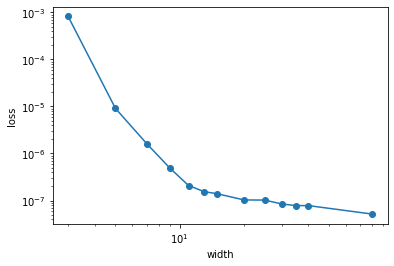

In [6]:
ws = [3,5,7,9,11,13,15,20,25,30,35,40,80]
plt.plot(ws, loss_w, marker="o")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('width')
plt.ylabel('loss',fontsize=10)
log_ws = np.log(ws)
log_loss = np.log(loss_w)

In [7]:
np.save('./additivity_results/lrelu_0d3_seq_double.npy', np.array([ws, loss_w]))

In [9]:
# The slope is wrong!

start_id = 0
end_id = -5

slope = (np.log(loss_w[start_id])-np.log(loss_w[end_id]))/(np.log(ws[start_id])-np.log(ws[end_id]))
slope

-4.114281037573

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy

reg = LinearRegression().fit(log_ws[:,np.newaxis], log_loss)
eps_max = np.min(loss_w)*0.999

num_sweep = 10001
eps0_sweep = np.linspace(0, eps_max, num=num_sweep)
scores = []

for i in range(num_sweep):
    score = np.abs(scipy.stats.pearsonr(log_ws, np.log(loss_w-eps0_sweep[i]))[0])
    scores.append(score)

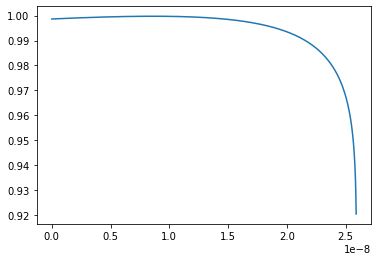

In [8]:
plt.plot(eps0_sweep, scores)

In [9]:
max_id = np.argmax(scores)
eps0 = eps0_sweep[max_id]
reg.fit(log_ws[:,np.newaxis], np.log(loss_w-eps0))
alpha = reg.coef_[0]
A = np.e**reg.intercept_
print(max_id)
print(eps0)
print(alpha)
print(A)
#[eps0, A, alpha]

3335
8.636227973173759e-09
-2.362263022998005
0.0005449319464341603


In [12]:
from scipy.optimize import minimize

def f(x):
    eps0 = x[0]
    A = x[1]
    alpha = x[2]
    return np.mean((loss_w-(A*ws**alpha+eps0))**2)

x0 = np.array([eps0, A, alpha])
sol = minimize(f, x0, tol=1e-16)
sol

      fun: 2.2213024996055152e-14
 hess_inv: array([[ 1.60272441e+00,  1.35903368e+04, -6.79134522e+05],
       [ 1.35903368e+04,  2.28644882e+08, -1.11283971e+10],
       [-6.79134522e+05, -1.11283971e+10,  5.42712598e+11]])
      jac: array([-1.13834817e-10, -2.50957776e-13, -5.37732747e-15])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 372
      nit: 51
     njev: 90
   status: 2
  success: False
        x: array([ 3.27677732e-07,  9.07975760e-03, -2.59048122e+00])

In [437]:
np.save('./additivity_results/{}_dict.npy'.format(delta), sol.x)

In [438]:
np.load('./additivity_results/{}_dict.npy'.format(delta))

array([ 3.14608724e-06,  1.99858136e-03, -1.65796907e+00])